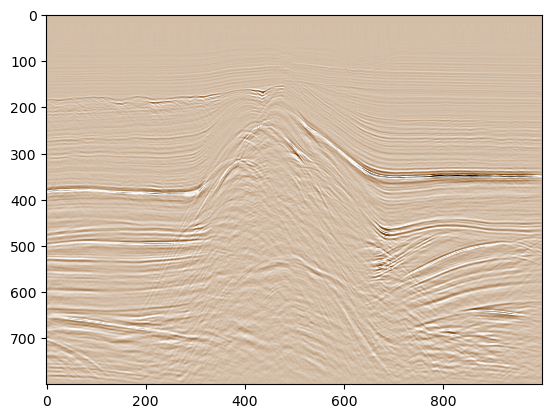

In [4]:
# First download data (Github allows file size < 25Mb)
# https://github.com/aaspip/data/blob/main/masha_field_800_1000.bin
# first read the data
def binread(fname,n1,n2=1,n3=1):
	'''
	
	EXAMPLE
	from pylib.io import binwrite,binread
	from pyseistr import gensyn
	din=gensyn();
	binwrite('data_400_1000.bin',din)
	
	data=binread('data_400_1000.bin',n1=400,n2=1000)
	import matplotlib.pyplot as plt
	plt.imshow(data);
	plt.show()
	'''
	import numpy as np
	fid=open(fname,"rb")
	data=np.fromfile(fid, dtype = np.float32, count = n1*n2*n3) ### remember double precision
	
	if n2==1 and n3==1:
		data=np.reshape(data,[n1],order='F')
	elif n3==1:
		data=np.reshape(data,[n1,n2],order='F')
	else:
		data=np.reshape(data,[n1,n2,n3],order='F')
	
	return data

original=binread('masha_field_800_1000.bin',n1=800,n2=1000,n3=1);

d1=0.004;d2=13.3; #in meter
o1=0;o2=0;

from matplotlib import pyplot as plt
from pyseistr import cseis
plt.imshow(original,cmap=cseis(),aspect='auto');
plt.title('Original');
plt.show()


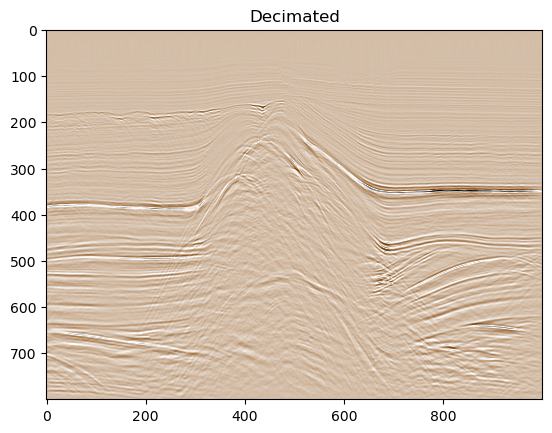

In [10]:
decimate=original[:,::2]
plt.imshow(original,cmap=cseis(),aspect='auto');
plt.title('Decimated');
plt.show()


In [9]:
decimate.shape

(800, 500)